In [1]:
from pyspark.sql.functions import rank, col, row_number
from pyspark.sql.window import Window
from pyspark.ml import Pipeline
from pyspark.ml.feature import RegexTokenizer, CountVectorizer, StringIndexer, VectorAssembler, HashingTF, IDF, NGram
from pyspark.ml.classification import LogisticRegression, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

Initiating the Spark Instance, and setting driver memory to 8G:

In [2]:
from pyspark import SparkConf
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").config(conf=SparkConf().set("spark.driver.memory", "6g")).getOrCreate()
# spark = SparkSession.builder.master("spark://localhost:7077").config(conf=SparkConf() \
#         .set("spark.driver.memory", "6g").set("spark.executor.memory", "6g")).getOrCreate()

Importing Data (one JSON record per line):

In [3]:
yelp_df = spark.read.json("yelp_academic_dataset_review.json")

In [4]:
yelp_df.show(5)

+--------------------+----+----------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|      date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+----------+-----+--------------------+-----+--------------------+------+--------------------+
|iCQpiavjjPzJ5_3gP...|   0|2011-02-25|    0|x7mDIiDB3jEiPGPHO...|    2|The pizza was oka...|     0|msQe1u7Z_XuqjGoqh...|
|pomGBqfbxcqPv14c3...|   0|2012-11-13|    0|dDl8zu1vWPdKGihJr...|    5|I love this place...|     0|msQe1u7Z_XuqjGoqh...|
|jtQARsP6P-LbkyjbO...|   1|2014-10-23|    1|LZp4UX5zK3e-c5ZGS...|    1|Terrible. Dry cor...|     3|msQe1u7Z_XuqjGoqh...|
|elqbBhBfElMNSrjFq...|   0|2011-02-25|    0|Er4NBWCmCD4nM8_p1...|    2|Back in 2005-2007...|     2|msQe1u7Z_XuqjGoqh...|
|Ums3gaP2qM3W1XcA5...|   0|2014-09-05|    0|jsDu6QEJHbwP2Blom...|    5|Delicious healthy...|     0|msQe1u7Z_XuqjGoqh...|
+--------------------+----+-----

Removing all columns that are irrelevant to the question at hand:

In [5]:
removeColumns = ['business_id', 'cool', 'date', 'funny', 'review_id', 'stars', 'useful']

yelp_df = yelp_df.select([column for column in yelp_df.columns if column not in removeColumns])
yelp_df.show(5)

+--------------------+--------------------+
|                text|             user_id|
+--------------------+--------------------+
|The pizza was oka...|msQe1u7Z_XuqjGoqh...|
|I love this place...|msQe1u7Z_XuqjGoqh...|
|Terrible. Dry cor...|msQe1u7Z_XuqjGoqh...|
|Back in 2005-2007...|msQe1u7Z_XuqjGoqh...|
|Delicious healthy...|msQe1u7Z_XuqjGoqh...|
+--------------------+--------------------+
only showing top 5 rows



Getting the count of users that have written more than 600 reviews on the site:

In [6]:
%%time
#users that have posted at least 600 reviews on yelp
users_df_600 = yelp_df.groupBy("user_id").count().filter("`count` >= 600").orderBy(col("count").desc())
print(str(users_df_600.count()))

76
CPU times: user 2.94 ms, sys: 7.08 ms, total: 10 ms
Wall time: 9.1 s


There are 76 users that have posted atleast 600 reviews on yelp. Now I will select only 600 reviews from each of the users to create a balanced dataset.

In [7]:
joinedDF = yelp_df.join(users_df_600, yelp_df.user_id == users_df_600.user_id).select(yelp_df["*"])

In [8]:
window = Window.partitionBy(joinedDF['user_id']).orderBy(joinedDF['text'].desc())
n = 600
top_user_reviews = joinedDF.select(col('*'), row_number().over(window).alias('row_number')).where(col('row_number') <= n)
top_user_reviews = top_user_reviews.select(col('text'), col('user_id'))

### Pipeline with Count Features
Generating counts of all the words for each review. Only words that occur in atleast 10 reviews will be considered and a maximum of 10000 words are considered. I have not removed the stopwords as the patterns amongst those words tend to represent the writing style of a particular user. Rare words are removed as the words have to occur in atleast 10 reviews.

In [9]:

# Split the words
regexTokenizer = RegexTokenizer(inputCol="text", outputCol="words", pattern="\\W")

#bag of words count
countVectors = CountVectorizer(inputCol="words", outputCol="features", vocabSize=10000, minDF=10)

# Changing the user id into class labels from [0, n). In this case it would be [0,76)
label_userID = StringIndexer(inputCol = "user_id", outputCol = "label")

pipelineCount = Pipeline(stages=[regexTokenizer, countVectors, label_userID])

# Fit the pipeline on all reviews
pipelineCountFit = pipelineCount.fit(top_user_reviews)
top_user_reviews_count_features = pipelineCountFit.transform(top_user_reviews)

Splitting Data into training and testing instances:

In [15]:
# Seed is set to 12345 for reproducibility
(train_Reviews, test_Reviews) = top_user_reviews_count_features.randomSplit([0.8, 0.2], seed = 12345)
print("Training Reviews Count: " + str(train_Reviews.count()))
print("Testing Reviews Count: " + str(test_Reviews.count()))

Training Reviews Count: 36437
Testing Reviews Count: 9163


### Classification with count features
#### Logistic Regression

In [16]:
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)

lrModel = lr.fit(train_Reviews)
predictions = lrModel.transform(test_Reviews)

## Some Reviews of label 0 that were classified correctly
predictions.filter(predictions['prediction'] == 0).select("text","user_id","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10)

+--------------------+--------------------+--------------------+-----+----------+
|                text|             user_id|         probability|label|prediction|
+--------------------+--------------------+--------------------+-----+----------+
|My family and I w...|UYcmGbelzRa0Q6Jqz...|[0.64675352361303...|  0.0|       0.0|
|This is a 3 1/2 s...|UYcmGbelzRa0Q6Jqz...|[0.54168812198784...|  0.0|       0.0|
|My fella purchase...|UYcmGbelzRa0Q6Jqz...|[0.34042386306421...|  0.0|       0.0|
|My OG Ryan B and ...|UYcmGbelzRa0Q6Jqz...|[0.31632163704568...|  0.0|       0.0|
|We came in during...|UYcmGbelzRa0Q6Jqz...|[0.26843193823418...|  0.0|       0.0|
|My fella and have...|UYcmGbelzRa0Q6Jqz...|[0.25175000723116...|  0.0|       0.0|
|This place is a g...|UYcmGbelzRa0Q6Jqz...|[0.21735182511012...|  0.0|       0.0|
|So, I'm not a big...|UYcmGbelzRa0Q6Jqz...|[0.19822862121262...|  0.0|       0.0|
|Ok, so I'm a litt...|UYcmGbelzRa0Q6Jqz...|[0.19467743226421...|  0.0|       0.0|
|I've been to th

In [17]:
## Some Reviews of label 0 that were classified incorrectly
predictions.filter(predictions['prediction'] == 0).filter(predictions['label'] != 0).select("text","user_id","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10)

+--------------------+--------------------+--------------------+-----+----------+
|                text|             user_id|         probability|label|prediction|
+--------------------+--------------------+--------------------+-----+----------+
|Popped in for a t...|hWDybu_KvYLSdEFzG...|[0.05254371652676...| 58.0|       0.0|
|For a chain resta...|Q4Qfu-3vYtL1LRm2X...|[0.05081986917789...| 12.0|       0.0|
|Pretty lame reall...|TbhyP24zYZqZ2VJZg...|[0.04010506544773...| 14.0|       0.0|
|It might be older...|N3oNEwh0qgPqPP3Em...|[0.03014759022500...| 30.0|       0.0|
|Jasons Deli has a...|qPVtjjp8sNQ32p986...|[0.02961978688386...| 74.0|       0.0|
|Located in a stri...|fiGqQ7pIGKyZ9G0Rq...|[0.02958824895102...| 33.0|       0.0|
|This is typically...|DK57YibC5ShBmqQl9...|[0.02932785823639...| 71.0|       0.0|
|I like this shopp...|N3oNEwh0qgPqPP3Em...|[0.02911326086531...| 30.0|       0.0|
|This is one of th...|DK57YibC5ShBmqQl9...|[0.02814461816914...| 71.0|       0.0|
|With Sur La Tab

In [18]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
logisticCountAccuracy = evaluator.evaluate(predictions)
print("Test set accuracy = " + str(logisticCountAccuracy))

Test set accuracy = 0.748101074606928


#### Naive Bayes using Count Feature Vector

In [19]:
nb = NaiveBayes(smoothing=1)
model = nb.fit(train_Reviews)

predictions = model.transform(test_Reviews)

In [20]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
nbCountAccuracy = evaluator.evaluate(predictions)
print("Test set accuracy = " + str(nbCountAccuracy))

Test set accuracy = 0.7567572758675017


### Pipeline with TFIDF Features
Generating a tfidf number of all the words for each review. Only words that occur in atleast 10 reviews will be considered and a maximum of 10000 words are considered. I have not removed the stopwords as the patterns amongst those words tend to represent the writing style of a particular user. Rare words are removed as the words have to occur in atleast 10 reviews.

In [21]:
%%time

reviewsTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=10000)
reviewsIdf = IDF(inputCol="rawFeatures", outputCol="features", minDocFreq=10)

pipeline = Pipeline(stages=[regexTokenizer, reviewsTF , reviewsIdf, label_userID])

pipelineTFIDFFit = pipeline.fit(top_user_reviews)
top_user_reviews_TFIDF_features = pipelineTFIDFFit.transform(top_user_reviews)

(train_TFIDF_Reviews, test_TFIDF_Reviews) = top_user_reviews_TFIDF_features.randomSplit([0.8, 0.2], seed = 12345)


CPU times: user 24.8 ms, sys: 69.1 ms, total: 93.9 ms
Wall time: 55.6 s


### Classification with TFIDF Features
#### Logistic Regression

In [22]:
%%time
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)

lrModelTFIDF = lr.fit(train_TFIDF_Reviews)
predictionsTFIDF = lrModelTFIDF.transform(test_TFIDF_Reviews)

CPU times: user 23.2 ms, sys: 68.5 ms, total: 91.7 ms
Wall time: 1min 17s


In [23]:
%%time
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
logisticTFIDFAccuracy = evaluator.evaluate(predictionsTFIDF)
print("Test set accuracy = " + str(logisticTFIDFAccuracy))

Test set accuracy = 0.7103316319556514
CPU times: user 3.45 ms, sys: 16.1 ms, total: 19.5 ms
Wall time: 46.7 s


#### Naive Bayes with TFIDF Features

In [24]:
%%time

nb = NaiveBayes(smoothing=1)
model = nb.fit(train_TFIDF_Reviews)

predictionsTFIDF = model.transform(test_TFIDF_Reviews)

CPU times: user 17.6 ms, sys: 17.4 ms, total: 35 ms
Wall time: 1min 5s


In [25]:
%%time
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
nbTFIDFAccuracy = evaluator.evaluate(predictionsTFIDF)
print("Test set accuracy = " + str(nbTFIDFAccuracy))

Test set accuracy = 0.6741608457475073
CPU times: user 13.6 ms, sys: 23.5 ms, total: 37.1 ms
Wall time: 55 s


### TFIDF Featrues with n-gram 1 and 2
TFIDF matrix created of 1 word and 2 word combinations that occur in atleast 10 documents, to a maximum of 10000. Models are trained on the combined features, and test instance predictions are made.

In [10]:
%%time

reviewsTF = HashingTF(inputCol="words", outputCol="rawFeatures_1", numFeatures=10000)
reviewsIdf = IDF(inputCol="rawFeatures_1", outputCol="features_1", minDocFreq=10)

ngram = NGram(n=2, inputCol="words", outputCol="ngrams_2")
reviewsTF2 = HashingTF(inputCol="ngrams_2", outputCol="rawFeatures_2", numFeatures=10000)
reviewsIdf2 = IDF(inputCol="rawFeatures_2", outputCol="features_2", minDocFreq=10)

pipeline1 = Pipeline(stages=[reviewsTF , reviewsIdf])

pipeline2 = Pipeline(stages=[ngram, reviewsTF2 , reviewsIdf2])

finalPipeline = Pipeline(stages=[regexTokenizer,pipeline1, pipeline2, 
    VectorAssembler(inputCols=["features_1", "features_2"], outputCol="features"),label_userID
])

pipelineTFIDF2Fit = finalPipeline.fit(top_user_reviews)
top_user_reviews_TFIDF2_features = pipelineTFIDF2Fit.transform(top_user_reviews)

(train_TFIDF2_Reviews, test_TFIDF2_Reviews) = top_user_reviews_TFIDF2_features.randomSplit([0.8, 0.2], seed = 12345)

CPU times: user 59 ms, sys: 137 ms, total: 196 ms
Wall time: 2min 8s


#### Logistic Regression

In [11]:
%%time
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)

lrModelTFIDF2 = lr.fit(train_TFIDF2_Reviews)
predictionsTFIDF2 = lrModelTFIDF2.transform(test_TFIDF2_Reviews)

CPU times: user 37.2 ms, sys: 49.5 ms, total: 86.7 ms
Wall time: 2min 35s


In [12]:
%%time
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
logisticTFIDF2Accuracy = evaluator.evaluate(predictionsTFIDF2)
print("Test set accuracy = " + str(logisticTFIDF2Accuracy))

Test set accuracy = 0.8021557376732369
CPU times: user 13.4 ms, sys: 27.1 ms, total: 40.5 ms
Wall time: 2min 1s


#### Naive Bayes

In [13]:
%%time
nb = NaiveBayes(smoothing=1)
modelTFIDF2 = nb.fit(train_TFIDF2_Reviews)

predictionsTFIDF2 = modelTFIDF2.transform(test_TFIDF2_Reviews)

CPU times: user 12 ms, sys: 33.3 ms, total: 45.3 ms
Wall time: 1min 25s


In [14]:
%%time
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
nbTFIDF2Accuracy = evaluator.evaluate(predictionsTFIDF2)
print("Test set accuracy = " + str(nbTFIDF2Accuracy))

Test set accuracy = 0.7294467450183251
CPU times: user 11.3 ms, sys: 25.8 ms, total: 37.1 ms
Wall time: 2min 2s


### Summary
Comparison of all accuracies given below.

/home/centos/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: 'from_array' is deprecated and will be removed in a future version. Please use the pd.Series(..) constructor instead.
  """


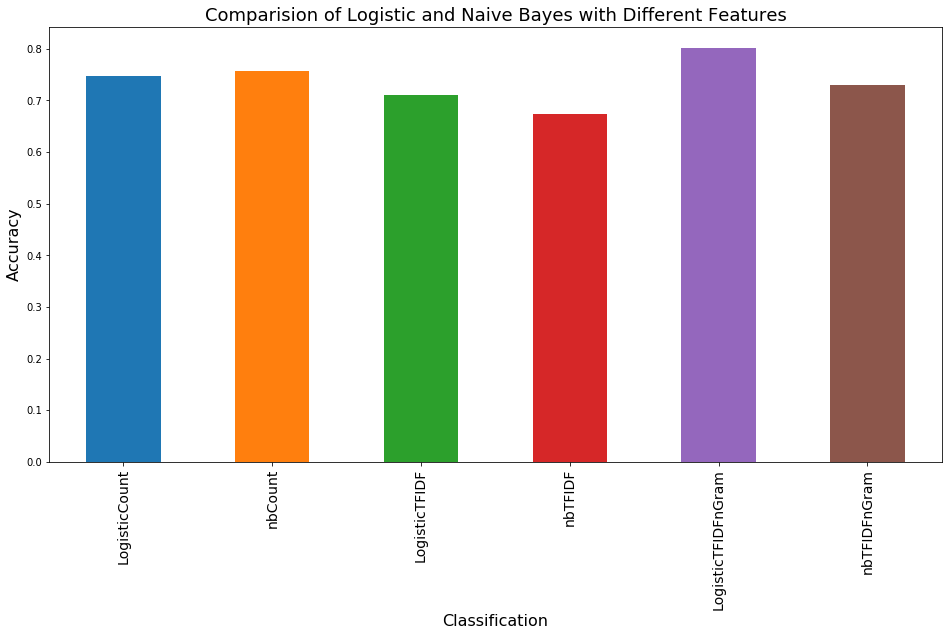

In [41]:
import pandas as pd

accuracies = [logisticCountAccuracy, nbCountAccuracy, logisticTFIDFAccuracy, nbTFIDFAccuracy, 
     logisticTFIDF2Accuracy, nbTFIDF2Accuracy]
accu_series = pd.Series.from_array(accuracies)

x_labels = [u'LogisticCount', u'nbCount', u'LogisticTFIDF', u'nbTFIDF', u'LogisticTFIDFnGram', u'nbTFIDFnGram']

plt.figure(figsize=(16, 8))
ax = accu_series.plot(kind='bar')
ax.set_title('Comparision of Logistic and Naive Bayes with Different Features', fontsize=18)
ax.set_xlabel('Classification', fontsize=16)
ax.set_ylabel('Accuracy', fontsize=16)
ax.set_xticklabels(x_labels, fontsize=14)

rects = ax.patches

#### Linear SVM MultiClass Classification

In [ ]:
# from pyspark.ml.classification import LinearSVC, OneVsRest

# lsvc = LinearSVC(maxIter=100, regParam=0.1)

# # instantiate the One Vs Rest with a Linear SVM base classifier
# ovr = OneVsRest(classifier=lsvc)

# # train the multiclass model.
# ovrModelTFIDF2 = ovr.fit(train_TFIDF2_Reviews)

# # score the model on test data.
# predictionsTFIDF2 = ovrModelTFIDF2.transform(test_TFIDF2_Reviews)

In [ ]:
# evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
# linearSVMAccuracy = evaluator.evaluate(predictionsTFIDF2)

### Cross-Validation
I apply cross-validation with logistic regression to 1 and 2-gram tfidf features as it provided the best result from the above runs. It has been commented out as it was running out of disk memory in the /tmp folder

In [ ]:
# %%time
# # Create ParamGrid for Cross Validation
# paramGrid = (ParamGridBuilder()
#              .addGrid(lr.regParam, [0.1, 0.3, 0.5])
#              .addGrid(lr.elasticNetParam, [0.0, 0.1, 0.2])
# #              .addGrid(lr.maxIter, [10, 20, 50])
#              .build())

# # 5-fold CrossValidator
# cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# cvModel = cv.fit(train_TFIDF2_Reviews)

# predictionsTFIDF2 = cvModel.transform(test_TFIDF2_Reviews)

In [ ]:
# # Evaluate best model
# evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
# logisticCrossValAccuracy = evaluator.evaluate(predictionsTFIDF2)
# print("Test set accuracy = " + str(logisticCrossValAccuracy))